In [331]:
import sys

import pandas 
import scipy

import matplotlib.pyplot
import seaborn

import networkx

sys.path.append("../scripts")
from utils import parse_interactome

In [332]:
def parse_scores(scores_file):
    # load scores
    scores = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            ENSG, gene, score = line_splitted
            scores[ENSG] = float(score)

    return scores

In [333]:
def parse_leave_one_out(scores_file):
    # load left-out scores
    scores_left_out = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            ENSG, gene, score = line_splitted
            scores_left_out[ENSG] = float(score)
        
    return scores_left_out

In [334]:
def check_pvalue(pvalue):
    if pvalue < 0.0001:
        return "p-value < 0.0001"
    if pvalue < 0.001:
        return "p-value < 0.001"
    if pvalue < 0.01:
        return "p-value < 0.01"
    if pvalue < 0.05:
        return "p-value < 0.05"
    else:
        return "p-value >= 0.05"

In [335]:
def compare_scores(scores, scores_left_out):
    scores = scores.copy()
    for left_out in scores_left_out:
        del scores[left_out]

    df_scores = pandas.DataFrame.from_dict(scores, 
                                       orient='index', 
                                       columns=['score'])
    df_scores['group'] = "non-causal"

    df_scores_left_out = pandas.DataFrame.from_dict(scores_left_out, 
                                                    orient='index', 
                                                    columns=['score'])

    df_scores_left_out['group'] = 'left-out'

    # concatenate dataframes for comparison
    df_compare = pandas.concat([df_scores, df_scores_left_out])

    stat, pvalue = scipy.stats.ranksums(df_scores['score'].values, df_scores_left_out['score'].values, alternative='less')

    pvalue_thresh = check_pvalue(pvalue)

    print(stat, pvalue)

    return df_compare, pvalue_thresh

In [336]:
def causal_genes_at_distance(dict_distances, node, d):
    try:
        return len([dist for dist in dict_distances.get(node).values() if dist == d])
    except:
        return 0

In [337]:
def geneName_to_ENSG(genes_file):
    genes = {}

    f = open(genes_file, 'r')
    
    # skip header
    next(f)

    for line in f:
        line_splitted = line.rstrip().split('\t')
        gene_name, ENSG = line_splitted

        genes[gene_name] = ENSG
    
    return genes

#### Set parameters

In [338]:
PHENOTYPE = "MMAF"
ALPHA = 0.5
D_MAX = 10
ALPHA_NORM = 1


#### Load the necessary data

In [339]:
interactome = parse_interactome(interactome_file="/home/kubicaj/calc/input/Interactome_human.sif")

alpha = str(ALPHA).replace('.', '')
scores = parse_scores(f"/home/kubicaj/calc/output/New_centrality_v8/{PHENOTYPE}/alpha{alpha}_dmax{D_MAX}_alphanorm_{ALPHA_NORM}/scores.tsv")
scores_leave_one_out = parse_leave_one_out(f"/home/kubicaj/calc/output/New_centrality_v8/{PHENOTYPE}/alpha{alpha}_dmax{D_MAX}_alphanorm_{ALPHA_NORM}/scores_leave_one_out.tsv")

#### Analyze leave-one-out results: newCentrality.py

In [340]:
df_compare, p_value = compare_scores(scores, scores_leave_one_out)

-0.9828981131949307 0.1628287932788411


Text(0.5, 1.0, 'Compare non-causal genes scores (all MMAF genes used)\n with scores for MMAF genes (leave-one-out)\nalpha=0.5,   d=10,    alpha_norm=1')

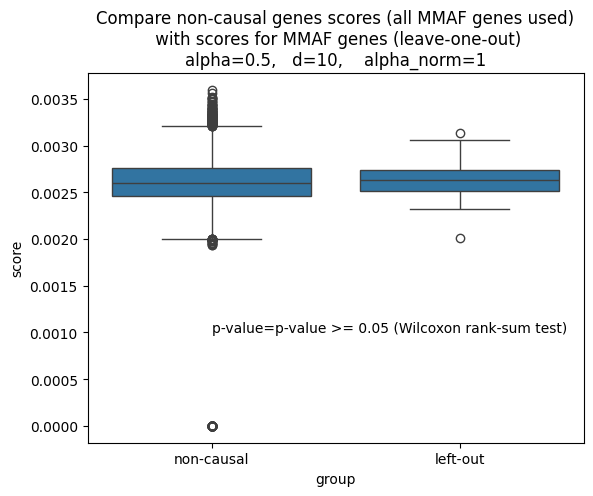

In [341]:
# plot
seaborn.boxplot(data=df_compare, x='group', y='score')
matplotlib.pyplot.text(0, 0.001, s=f"p-value={p_value} (Wilcoxon rank-sum test)")
matplotlib.pyplot.title(f"Compare non-causal genes scores (all {PHENOTYPE} genes used)\n with scores for {PHENOTYPE} genes (leave-one-out)\nalpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}")
# matplotlib.pyplot.ylim(0,2)

In [342]:
# top 10 high-scoring genes
scores_sorted = {node: score for node, score in sorted(scores.items(), key=lambda item: item[1], reverse=True)}
scores_sorted

{'ENSG00000075240': 0.0035950015288531492,
 'ENSG00000133393': 0.003566007187807256,
 'ENSG00000122026': 0.0035241669174028343,
 'ENSG00000187735': 0.0035133957150056527,
 'ENSG00000068394': 0.0035114670976651575,
 'ENSG00000005448': 0.0034967772022451325,
 'ENSG00000149761': 0.003494512675113844,
 'ENSG00000025708': 0.0034773890617431566,
 'ENSG00000118965': 0.0034694481754240073,
 'ENSG00000123607': 0.0034694481754240073,
 'ENSG00000135362': 0.003448560888177357,
 'ENSG00000077935': 0.0034337299929665215,
 'ENSG00000183035': 0.0034337299929665215,
 'ENSG00000137776': 0.0034317714151853333,
 'ENSG00000155875': 0.003431302192066806,
 'ENSG00000125457': 0.003413057103705934,
 'ENSG00000183963': 0.003405438015351463,
 'ENSG00000092020': 0.003403414743843103,
 'ENSG00000187535': 0.003399313699696035,
 'ENSG00000051825': 0.0033965644110418927,
 'ENSG00000163545': 0.0033909806084533207,
 'ENSG00000068400': 0.0033897570006538574,
 'ENSG00000138587': 0.003384120121455358,
 'ENSG00000197724': 

In [343]:
len(scores), len(scores_sorted)

(14393, 14393)

#### Analyze new candidates from 13/02/2024

In [344]:
genes = geneName_to_ENSG("/home/kubicaj/calc/input/canonicalGenes.tsv")

In [345]:
new_candidates_names = ['CLHC1', 'PHF20', 'NUSAP1', 'CDC20B', 'FAM221A', 'GALR3', 'LRRC9', 'KIF27', 'ZNF208', 'C6orf118', 'CCDC66', 'CCNA1', 'DDX43', 'FSCB', 'FHAD1', 'LRGUK', 'MYCBPAP', 'MYH7B', 'PCDHB15', 'SAMD15', 'SPACA9', 'SPATA24', 'SPATA6', 'TSSK4', 'TTLL2']
new_candidates_ENSG = [genes.get(n) for n in new_candidates_names]
new_candidates = [n for n in new_candidates_ENSG if n in interactome]

In [346]:
# check scores of new candidates
scores_new_candidates = {n: scores.get(n) for n in new_candidates}

In [347]:
scores_new_candidates

{'ENSG00000162994': 0.0027092570834784764,
 'ENSG00000025293': 0.0025751852200173466,
 'ENSG00000164287': 0.0025052544950024936,
 'ENSG00000188732': 0.0029044904448999277,
 'ENSG00000128310': 0.002623177979611357,
 'ENSG00000165115': 0.002879730012375159,
 'ENSG00000180376': 0.003135021917464318,
 'ENSG00000133101': 0.0027237637088147826,
 'ENSG00000080007': 0.0,
 'ENSG00000142621': 0.0031035088308287474,
 'ENSG00000136449': 0.0026148378610816006,
 'ENSG00000078814': 0.0026110181837802836,
 'ENSG00000165698': 0.00276371403618627,
 'ENSG00000170469': 0.0026876697687127312,
 'ENSG00000132122': 0.0027314090849143696,
 'ENSG00000139908': 0.0025056475538577884,
 'ENSG00000120440': 0.002511698406723125}

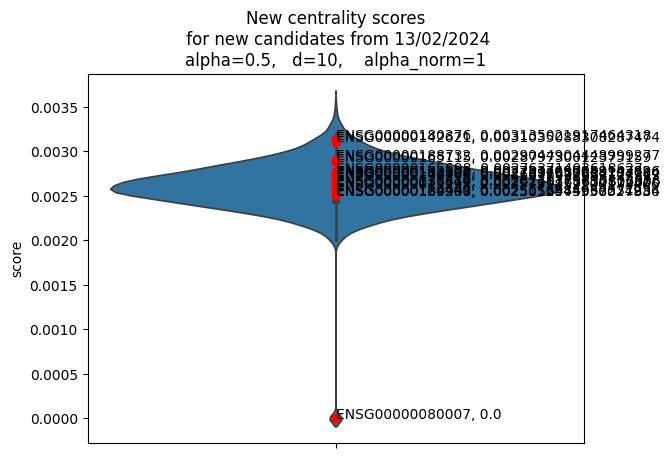

In [348]:
seaborn.violinplot(data=df_compare, y='score')
matplotlib.pyplot.title(f"New centrality scores\n for new candidates from 13/02/2024\nalpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}")

for canidate, score in scores_new_candidates.items():
    matplotlib.pyplot.plot(score, 'or')
    matplotlib.pyplot.text(0, score, s=f"{canidate}, {score}")

### Compare New centrality with other centralities (degree, betweenness)

In [359]:
CENTRALITY = "betweenness"

In [360]:
import utils

In [361]:
interactome = utils.parse_interactome(interactome_file="/home/kubicaj/calc/input/Interactome_human.sif")
(ENSG2gene, gene2ENSG) = utils.parse_gene2ENSG(gene2ENSG_file="/home/kubicaj/calc/input/canonicalGenes.tsv")
causal_genes = utils.parse_causal_genes(causal_genes_file="/home/kubicaj/calc/input/causalGenes_allPhenotypes.csv", gene2ENSG=gene2ENSG, interactome=interactome, patho=PHENOTYPE)

gene LINC01505 mapped to multiple ENSGs, keeping the first == ENSG00000234229
gene ITFG2-AS1 mapped to multiple ENSGs, keeping the first == ENSG00000256150
gene LINC01238 mapped to multiple ENSGs, keeping the first == ENSG00000237940
gene GOLGA8M mapped to multiple ENSGs, keeping the first == ENSG00000188626
gene TMSB15B mapped to multiple ENSGs, keeping the first == ENSG00000158427
gene POLR2J4 mapped to multiple ENSGs, keeping the first == ENSG00000214783
gene MATR3 mapped to multiple ENSGs, keeping the first == ENSG00000015479
causal gene AK7 == ENSG00000140057 is not in interactome, skipping it
causal gene CCDC39 == ENSG00000145075 is not in interactome, skipping it
causal gene CFAP251 is not in gene2ENSG, skipping it
causal gene CFAP43 == ENSG00000197748 is not in interactome, skipping it
causal gene CFAP52 == ENSG00000166596 is not in interactome, skipping it
causal gene CFAP61 == ENSG00000089101 is not in interactome, skipping it
causal gene CFAP70 == ENSG00000156042 is not in i

In [362]:
scores_causal = {node: score for node, score in scores.items() if node in causal_genes}
scores_causal_sorted = {node: score for node, score in sorted(scores_causal.items(), key=lambda item: item[1], reverse=True)}

In [363]:
scores_centrality = parse_scores(f"/home/kubicaj/calc/output/{CENTRALITY}_centrality/{PHENOTYPE}/scores.tsv")
scores_centrality = {node: score for node, score in scores_centrality.items() if node in scores}
scores_centrality_sorted = {node: score for node, score in sorted(scores_centrality.items(), key=lambda item: item[1], reverse=True)}

scores_centrality_causal = {node: score for node, score in scores_centrality.items() if node in causal_genes}
scores_centrality_causal_sorted = {node: score for node, score in sorted(scores_centrality_causal.items(), key=lambda item: item[1], reverse=True)} 

In [364]:
len(scores_sorted.values()), len(scores_centrality_sorted.values())

(14393, 14393)

Text(0.5, 0, 'betweenness centrality')

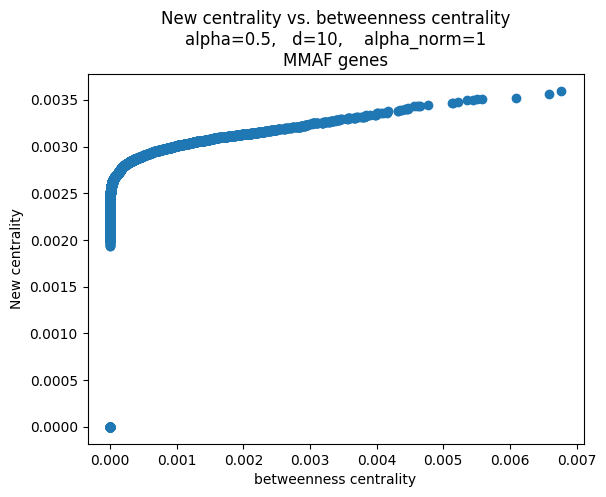

In [369]:
matplotlib.pyplot.scatter(x=scores_centrality_sorted.values(), y=scores_sorted.values())
matplotlib.pyplot.title(f"New centrality vs. {CENTRALITY} centrality\nalpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}\n{PHENOTYPE} genes")
matplotlib.pyplot.ylabel("New centrality")
matplotlib.pyplot.xlabel(f"{CENTRALITY} centrality")

In [366]:
len(scores_causal_sorted), len(scores_centrality_causal_sorted)

(41, 41)

Text(0.5, 0, 'betweenness centrality')

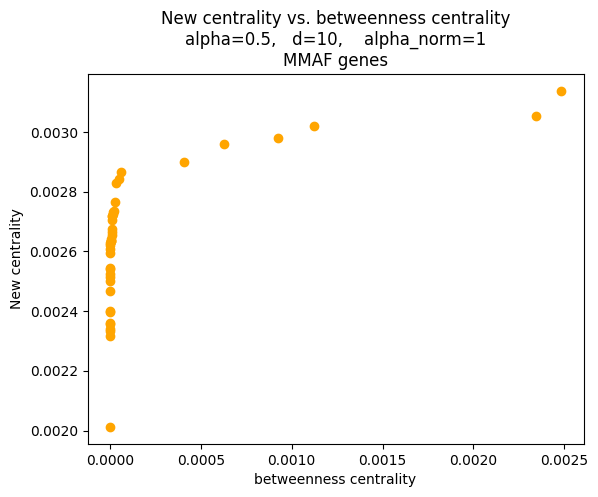

In [367]:
matplotlib.pyplot.scatter(x=scores_centrality_causal_sorted.values(), y=scores_causal_sorted.values(), c='orange')
matplotlib.pyplot.title(f"New centrality vs. {CENTRALITY} centrality\nalpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}\n{PHENOTYPE} genes")
matplotlib.pyplot.ylabel("New centrality")
matplotlib.pyplot.xlabel(f"{CENTRALITY} centrality")